# **CPEN 355 Project - Music Genre Classifier**

*   Idil Bil 
*   Mehmet Berke Karadayi
*   Peter Na 

## Initializations

In [2]:
# Enable import for BayesSearchCV
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.6 MB/s eta 0:00:00


In [3]:
# Import necessary libraries for numerical operations, array handling, data manipulation, and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import machine learning components from scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Import preprocessing and pipeline tools
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Import table formatting library for better output display
from tabulate import tabulate

# Import BayesSearch to find optimal hyperparameters
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real

## Data Processing

In [4]:
# Read the .CSV data
music_data_raw = pd.read_csv("sample_data/music_genre.csv")

# Drop the irrelevant columns to the classification and rows with missing cells in any column
music_data_filter = (
    music_data_raw
    .replace('?', np.nan)                                                               # Replace cells with '?' with NaN(blank)
    .dropna()                                                                           # Drop rows with any blank values
    .drop(columns=['instance_id','artist_name', 'track_name', 'obtained_date'])
)

# Use one-hot encoding for categorical/string variables
music_data = pd.get_dummies(music_data_filter, columns=['key', 'mode'], drop_first=True, dtype=int)

print('DATASET AFTER CLEANING')
print(tabulate(music_data.head(10), headers='keys', tablefmt='grid'))

DATASET AFTER CLEANING
+----+--------------+----------------+----------------+---------------+----------+--------------------+------------+------------+---------------+---------+-----------+---------------+----------+---------+---------+----------+---------+----------+---------+---------+----------+---------+----------+--------------+
|    |   popularity |   acousticness |   danceability |   duration_ms |   energy |   instrumentalness |   liveness |   loudness |   speechiness |   tempo |   valence | music_genre   |   key_A# |   key_B |   key_C |   key_C# |   key_D |   key_D# |   key_E |   key_F |   key_F# |   key_G |   key_G# |   mode_Minor |
+====+==============+================+================+===============+==========+====================+============+============+===============+=========+===========+===============+==========+=========+=========+==========+=========+==========+=========+=========+==========+=========+==========+==============+
|  0 |           27 |        0.0046

## Data Visualization

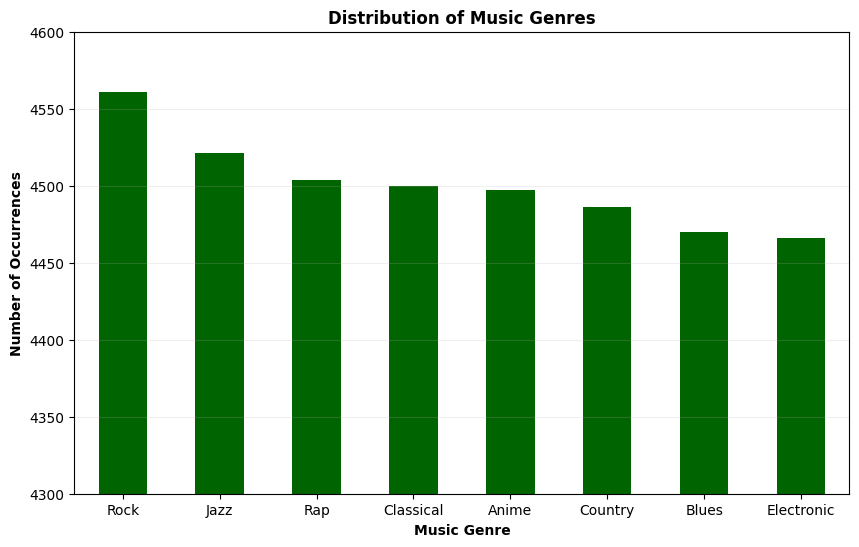

In [5]:
# Count the occurrences of each music genre
genre_counts = music_data['music_genre'].value_counts()

# Create a bar plot to visualize the balance of the dataset
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='darkgreen')
plt.title('Distribution of Music Genres', fontweight='bold')
plt.xlabel('Music Genre', fontweight='bold')
plt.ylabel('Number of Occurrences', fontweight='bold')
plt.xticks(rotation=0)                                          # Rotate the x-axis labels for readibility
plt.ylim(4300, 4600)                                            # Limit the y-axis min and max values to see the counts clearly
plt.grid(axis='y', linestyle='-', alpha=0.2)
plt.show()

# Model 1 - Random Forest

## Training

In [ ]:
# Separate the features and target variable from the dataset
X = music_data.drop(columns=['music_genre'])                  # X contains all features except the target ('music_genre')
y = music_data['music_genre']                                 # y contains only the target variable ('music_genre')

# Split the data: 70% training, 20% validation, 10% testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)        # 70% training, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)  # 20% validation, 10% testing

# Define the parameter space for RandomForestClassifier
param_space_rfc = {
    'classifier__n_estimators': Integer(500, 1000),               # Search over fewer trees
    'classifier__max_depth': Integer(10, 30),                     # Max depth of trees
    'classifier__min_samples_split': Integer(2, 20),              # Minimum samples to split a node
    'classifier__min_samples_leaf': Integer(1, 10),               # Minimum samples in a leaf node
    'classifier__max_features': Categorical(['sqrt', 'log2']),    # Feature selection strategy
}

# Create the RFC pipeline with StandardScaler and RandomForestClassifier
rfc = Pipeline([
    ('scaler', StandardScaler()),                             # Standardize features
    ('classifier', RandomForestClassifier(random_state=42))   # Random Forest model with base hyperparameters
])

# Set up BayesSearchCV for RandomForestClassifier
bayes_search_RFC = BayesSearchCV(
    estimator=rfc,                                # Use the pipeline as the estimator
    search_spaces=param_space_rfc,                # Parameter space to search
    cv=3,                                         # Use 3-fold cross-validation to save time
    n_iter=50,                                    # Number of parameter settings sampled (more means longer search)
    scoring='accuracy',                           # Use accuracy as the evaluation metric
    n_jobs=-1,                                    # Use all available cores to speed up computation
    verbose=1,                                    # Print progress to monitor the search process
)

# Fit BayesSearchCV on the training data
bayes_search_RFC.fit(X_train, y_train)

# Extract the best model
best_rfc = bayes_search_RFC.best_estimator_

# Print the best parameters and best score found by BayesSearchCV
print("Best parameters found: ", bayes_search_RFC.best_params_)
print("Best cross-validation accuracy: ", bayes_search_RFC.best_score_)

# Print the split of the datasets and the end of training
print(f'Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}')
print("Random Forest classifier has been trained.")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found:  OrderedDict([('classifier__max_depth', 18), ('classifier__max_features', 'log2'), ('classifier__min_samples_leaf', 4), ('classifier__min_samples_split', 4), ('classifier__n_estimators', 500)])
Best cross-validation accuracy:  0.6967027734793477
Training set: (25203, 23), Validation set: (7201, 23), Test set: (3601, 23)
Random Forest classifier has been trained.


## Validation

In [ ]:
# Perform cross-validation on the validation data to evaluate the model's performance
cv_results = cross_validate(bayes_search_RFC.best_estimator_, X_val, y_val, cv=5, return_train_score=True)

# Convert the cross-validation results into a DataFrame for easier visualization and analysis
cv_results_df = pd.DataFrame(cv_results)

# Print the DataFrame to display the cross-validation scores for each fold
print(cv_results_df)

   fit_time  score_time  test_score  train_score
0  5.434311    0.154588    0.682165     0.904167
1  6.316350    0.167892    0.664583     0.901232
2  5.891382    0.178977    0.692361     0.905225
3  5.554878    0.120275    0.685417     0.902968
4  5.648211    0.150435    0.672222     0.900712


## Testing

In [ ]:
# Use the trained RF classifier to predict labels for the test data
y_pred = bayes_search_RFC.best_estimator_.predict(X_test)

## Results

Overall Report - Random Forest Classifier
-------------------------------
Accuracy: 0.7050819216884199
-------------------------------
              precision    recall  f1-score   support

       Anime       0.80      0.75      0.77       457
       Blues       0.61      0.57      0.59       415
   Classical       0.84      0.85      0.84       478
     Country       0.69      0.66      0.68       470
  Electronic       0.65      0.62      0.63       435
        Jazz       0.58      0.56      0.57       459
         Rap       0.84      0.80      0.82       444
        Rock       0.63      0.82      0.71       443

    accuracy                           0.71      3601
   macro avg       0.71      0.70      0.70      3601
weighted avg       0.71      0.71      0.70      3601



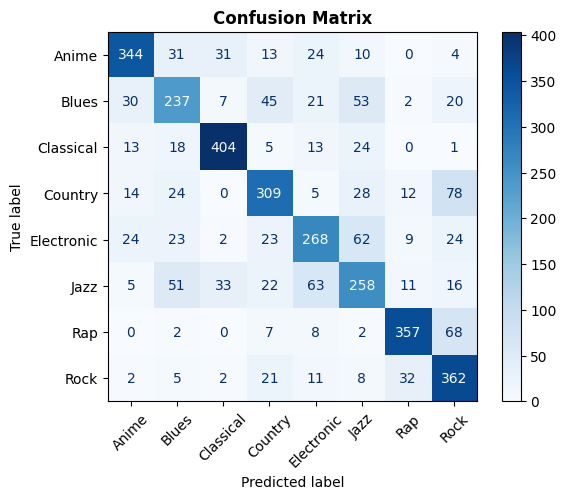

In [ ]:
# Print the overall performance report
print("Overall Report - Random Forest Classifier")
print("-------------------------------")
accuracy_rf = accuracy_score(y_test, y_pred)                                                    # Calculate the accuracy score
print(f'Accuracy: {accuracy_rf}')                                                               # Print the calculated accuracy
print("-------------------------------")
class_report_rf = classification_report(y_test, y_pred)                                         # Generate the classification report
print(class_report_rf)                                                                          # Print the classification report (includes: precision, recall, and F1-score for each class)

# Plot the confusion matrix for the RF model
conf_matrix_rf = confusion_matrix(y_test, y_pred)                                               # Generate the confusion matrix
disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=bayes_search_RFC.classes_)
disp_rf.plot(cmap=plt.cm.Blues)                                                                 # Display the confusion matrix
plt.xticks(rotation=45)
plt.title('Confusion Matrix', fontweight='bold')
plt.show()

# Model 2 - Support Vector

##Training

In [7]:
# Separate the features and target variable from the dataset
X = music_data.drop(columns=['music_genre'])                  # X contains all features except the target ('music_genre')
y = music_data['music_genre']                                 # y contains only the target variable ('music_genre')

# Split the data: 70% training, 20% validation, 10% testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)        # 70% training, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)  # 20% validation, 10% testing

# Define the parameter space for SVC
param_space_svc = {
    'classifier__C': Real(0.1, 10),                                   # Regularization parameter (controls margin hardness)
    'classifier__gamma': Categorical(['scale', 0.1, 0.01, 0.001]),    # Gamma controls influence of individual points
    'classifier__kernel': Categorical(['rbf']),                       # Use only 'rbf' kernel for SVC
}

# Create the SVC pipeline with StandardScaler and Support Vector Classifier
svc = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(random_state=42))         # SVC initialized without specifying parameters
])

# Set up BayesSearchCV for SVC
bayes_search_SVC = BayesSearchCV(
    estimator=svc,                              # Use the pipeline as the estimator
    search_spaces=param_space_svc,              # Parameter grid to search
    cv=3,                                       # 3-fold cross-validation for faster runtime
    n_iter=20,                                  # Number of parameter settings sampled
    scoring='accuracy',                         # Optimize for accuracy score
    n_jobs=-1,                                  # Use all available cores
    verbose=1,                                  # Output progress to the console
)

# Fit BayesSearchCV on the training data
bayes_search_SVC.fit(X_train, y_train)

# Extract the best model
best_svc = bayes_search_SVC.best_estimator_

# Use the best model to make predictions on the validation set
y_val_pred_svc = best_svc.predict(X_val)

# Print the best parameters and best score found by BayesSearchCV
print("Best parameters found: ", bayes_search_SVC.best_params_)
print("Best cross-validation accuracy: ", bayes_search_SVC.best_score_)

# Print the split of the datasets and the end of training
print(f'Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}')
print("Random Forest classifier has been trained.")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

##Validation

In [8]:
# Perform cross-validation on the validation data to evaluate the model's performance
cv_results = cross_validate(bayes_search_SVC.best_estimator_, X_val, y_val, cv=5, return_train_score=True)

# Convert the cross-validation results into a DataFrame for easier visualization and analysis
cv_results_df = pd.DataFrame(cv_results)

# Print the DataFrame to display the cross-validation scores for each fold
print(cv_results_df)

   fit_time  score_time  test_score  train_score
0  1.964549    0.807659    0.639833     0.706597
1  1.145603    0.455134    0.638889     0.711161
2  1.187437    0.488600    0.650000     0.707690
3  1.158072    0.464165    0.654861     0.704739
4  1.908266    0.713525    0.634028     0.709078


##Testing

In [9]:
# Use the trained SV classifier to predict labels for the test data
y_pred = bayes_search_SVC.best_estimator_.predict(X_test)

##Results

Overall Report - Support Vector Classifier
-------------------------------
Accuracy: 0.6792557622882532
-------------------------------
              precision    recall  f1-score   support

       Anime       0.73      0.71      0.72       457
       Blues       0.57      0.58      0.57       415
   Classical       0.83      0.82      0.82       478
     Country       0.63      0.65      0.64       470
  Electronic       0.60      0.61      0.61       435
        Jazz       0.57      0.47      0.51       459
         Rap       0.84      0.80      0.82       444
        Rock       0.64      0.78      0.71       443

    accuracy                           0.68      3601
   macro avg       0.68      0.68      0.68      3601
weighted avg       0.68      0.68      0.68      3601



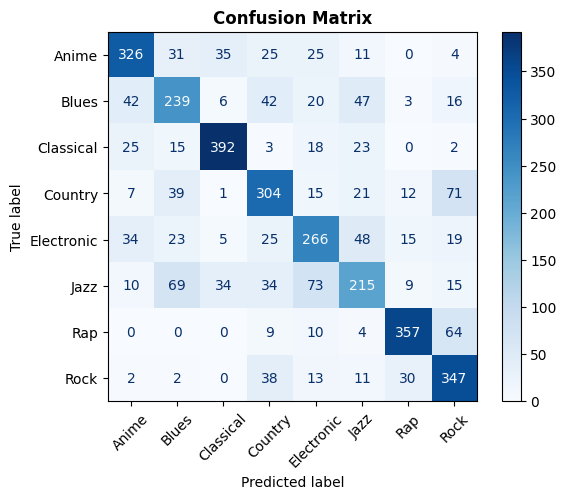

In [10]:
# Print the overall performance report
print("Overall Report - Support Vector Classifier")
print("-------------------------------")
accuracy_sv = accuracy_score(y_test, y_pred)                                                    # Calculate the accuracy score
print(f'Accuracy: {accuracy_sv}')                                                               # Print the calculated accuracy
print("-------------------------------")
class_report_sv = classification_report(y_test, y_pred)                                         # Generate the classification report
print(class_report_sv)                                                                          # Print the classification report (includes: precision, recall, and F1-score for each class)

# Plot the confusion matrix for the SV model
conf_matrix_sv = confusion_matrix(y_test, y_pred)                                               # Generate the confusion matrix
disp_sv = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_sv, display_labels=bayes_search_SVC.classes_)
disp_sv.plot(cmap=plt.cm.Blues)                                                                 # Display the confusion matrix
plt.xticks(rotation=45)
plt.title('Confusion Matrix', fontweight='bold')
plt.show()